In [1]:
import copy
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.linalg as linalg
import torch_geometric.utils as utils
import torch_geometric.nn as gnn
from prettytable import PrettyTable
from sklearn.metrics import f1_score
from torch import Tensor
from torch.distributions import Bernoulli, MultivariateNormal
from torch.nn import Parameter
from torch.utils.data import Dataset, DataLoader
from torch_geometric.data import Data
from torch_geometric.nn.conv import MessagePassing
from torch_geometric.nn.inits import zeros
from torch_scatter import scatter_add
from torch_sparse import SparseTensor, fill_diag, matmul, mul
from torch_sparse import sum as sparsesum
from torch_geometric.datasets import Planetoid
from torch_geometric.typing import Adj, OptTensor, PairTensor
from torch_geometric.utils.num_nodes import maybe_num_nodes
from typing import Optional, Tuple
torch.set_printoptions(precision=2,sci_mode=False, linewidth=200)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print('Using device:', device)
loss_fn = nn.BCEWithLogitsLoss()

Using device: cuda


## Data Model and Learners

In [2]:
class XCSBM:
    def __init__(self, n_points, n_features, dist_sd_ratio, sig_sq=None, p=1., q=0.):
        self.n_points = n_points
        self.n_features = n_features
        self.K = dist_sd_ratio
        self.sig_sq = 1./n_features if sig_sq is None else sig_sq
        self.p = p
        self.q = q
        # Fix a random pair of orthogonal means.
        u = torch.rand(n_features) # First mean.
        v = torch.rand(n_features) # Second mean.
        v[-1] = -(u[:-1] @ v[:-1]) / u[-1] # Make v orthogonal to u.
        u /= linalg.norm(u)
        v /= linalg.norm(v)
        self.normed_uv = torch.stack((u, v))
        
    # The XGMM synthetic data model definition.
    def xgmm(self):
        # Make K = norm(u-v) = sqrt(2)*norm(u).
        K_ = self.K/np.sqrt(2.0)
        u = K_*self.normed_uv[0]
        v = K_*self.normed_uv[1]
        X = torch.zeros((self.n_points, self.n_features))
        y = torch.zeros(self.n_points, dtype=torch.long)
        # Decide class and cluster based on two independent Bernoullis.
        eps = Bernoulli(torch.tensor([0.5]))
        eta = Bernoulli(torch.tensor([0.5]))
        for i in range(self.n_points):
            y[i] = eps.sample()
            cluster = eta.sample()
            # Mean is -mu, mu, -nu or nu based on eps_i and eta_i.
            mean = (2*cluster - 1)*((1-y[i])*u + y[i]*v)
            if self.sig_sq > 0:
                cov = torch.eye(self.n_features) * self.sig_sq
                distr = MultivariateNormal(mean, cov)
                X[i] = distr.sample()
            else:
                X[i] = mean
        return Data(x=X, y=y, edge_index=None)

    # Generate a dataset from the XCSBM synthetic data model.
    def generate_data(self):
        data = self.xgmm()
        # The inbuilt function stochastic_blockmodel_graph does not support
        # random permutations of the nodes, hence, design it manually.
        # Use with_replacement=True to include self-loops.
        probs = torch.tensor([[self.p, self.q], [self.q, self.p]], dtype=torch.float)
        row, col = torch.combinations(torch.arange(self.n_points), r=2, with_replacement=True).t()
        mask = torch.bernoulli(probs[data.y[row], data.y[col]]).to(torch.bool)
        data.edge_index = torch.stack([row[mask], col[mask]], dim=0)
        data.edge_index = utils.to_undirected(data.edge_index, num_nodes=self.n_points)
        return data

In [3]:
# MLP with ReLU activations and sigmoidal output.
class MLP(torch.nn.Module):
    def __init__(self, n_layers, n_features, channels=None):
        super().__init__()
        self.n_layers = n_layers
        self.activations = [nn.ReLU()]*n_layers
        self.activations[-1] = nn.Identity()
        self.dropout = nn.Dropout(0.5)
        # Set default number of channels for every layer if not specified.
        # channels[0] stores input dimensions for each layer.
        # channels[1] stores output dimensions for each layer.
        if channels is None:
            in_channels = [4]*n_layers
            in_channels[0] = n_features
            out_channels = [4]*n_layers
            out_channels[-1] = 1
            channels = [in_channels, out_channels]
        
        self.module_list = []
        for i in range(n_layers):
            self.module_list.append(nn.Sequential(
                nn.Linear(channels[0][i], channels[1][i], bias=False),
                self.activations[i]
            ))
        self.module_list = nn.ModuleList(self.module_list)

    def forward(self, data):
        x = data.x
        for (i, module) in enumerate(self.module_list):
            x = module(x)
        return torch.squeeze(x, dim=1)

def gcn_norm(edge_index, edge_weight=None, num_nodes=None, dtype=None):
    fill_value = 1.
    num_nodes = maybe_num_nodes(edge_index, num_nodes)
    if edge_weight is None:
        edge_weight = torch.ones((edge_index.size(1), ), dtype=dtype, device=edge_index.device)
    
    edge_index, tmp_edge_weight = utils.add_remaining_self_loops(edge_index, edge_weight, fill_value, num_nodes)
    assert tmp_edge_weight is not None
    edge_weight = tmp_edge_weight

    row, col = edge_index[0], edge_index[1]
    deg = scatter_add(edge_weight, col, dim=0, dim_size=num_nodes)
    deg_inv = deg.pow_(-1.)
    deg_inv.masked_fill_(deg_inv == float('inf'), 0)
    return edge_index, deg_inv[row] * edge_weight
    
# GCNConv module modified to consider multiple convolutions.
class GraphConv(MessagePassing):
    _cached_edge_index: Optional[Tuple[Tensor, Tensor]]
    _cached_adj_t: Optional[SparseTensor]

    def __init__(self, in_channels: int, out_channels: int, bias: bool = True, num_convs: int = 1, **kwargs):
        kwargs.setdefault('aggr', 'add')
        super().__init__(**kwargs)

        self.in_channels = in_channels
        self.out_channels = out_channels
        self.num_convs = num_convs

        self._cached_edge_index = None
        self._cached_adj_t = None

        self.lin = nn.Linear(in_channels, out_channels, bias=False)

        if bias:
            self.bias = Parameter(torch.Tensor(out_channels))
        else:
            self.register_parameter('bias', None)

        self.reset_parameters()

    def reset_parameters(self):
        self.lin.reset_parameters()
        zeros(self.bias)
        self._cached_edge_index = None
        self._cached_adj_t = None

    def forward(self, x: Tensor, edge_index: Adj, edge_weight: OptTensor = None) -> Tensor:
        edge_index, edge_weight = gcn_norm(  # yapf: disable
            edge_index, edge_weight, x.size(self.node_dim))
        x = self.lin(x)

        # propagate_type: (x: Tensor, edge_weight: OptTensor)
        out = x
        for i in range(self.num_convs):
            out = self.propagate(edge_index, x=out, edge_weight=edge_weight, size=None)

        if self.bias is not None:
            out += self.bias

        return out

    def message(self, x_j: Tensor, edge_weight: OptTensor) -> Tensor:
        return x_j if edge_weight is None else edge_weight.view(-1, 1) * x_j

    def message_and_aggregate(self, adj_t: SparseTensor, x: Tensor) -> Tensor:
        return matmul(adj_t, x, reduce=self.aggr)
    
# MLP with ReLU activations and sigmoidal output.
class GCN(torch.nn.Module):
    def __init__(self, n_layers, n_features, convolutions, channels=None):
        super().__init__()
        self.n_layers = n_layers
        self.convs = convolutions
        self.activations = [nn.ReLU()]*n_layers
        self.activations[-1] = nn.Identity()
        # Set default number of channels for every layer if not specified.
        # channels[0] stores input dimensions for each layer.
        # channels[1] stores output dimensions for each layer.
        if channels is None:
            in_channels = [4]*n_layers
            in_channels[0] = n_features
            out_channels = [4]*n_layers
            out_channels[-1] = 1
            channels = [in_channels, out_channels]
        
        self.module_list = []
        for i in range(n_layers):
            self.module_list.append(GraphConv(channels[0][i], channels[1][i], num_convs=self.convs[i], bias=False))
        self.module_list = nn.ModuleList(self.module_list)

    def forward(self, data):
        x = data.x
        edge_index = data.edge_index
        for (i, module) in enumerate(self.module_list):
            x = module(x, edge_index)
            x = self.activations[i](x)
        return torch.squeeze(x, dim=1)

def train_model(model, data, loss_fn, lr=0.01, epochs=500, eps=1e-8, logs=None):
    model.train()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=1.0e-3)
    epoch = 0
    print_freq = 20
    prev_loss = 0
    wspace = 8*' '
    while epoch < epochs:
        optimizer.zero_grad(set_to_none=True)
        out = model(data)
        loss = loss_fn(out, data.y.float())
        loss.backward()
        optimizer.step()
        if logs is not None and epoch % print_freq == 0:
            print(logs + ' Loss: ' + str(round(loss.item(), 5)) + wspace, end='\r')
        if np.abs(prev_loss - loss.item()) <= eps and loss.item() < eps:
            break
        epoch += 1
        prev_loss = loss.item()

def train_one_epoch(model, optimizer, data, loss_fn):
    optimizer.zero_grad(set_to_none=True)
    out = model(data)
    loss = loss_fn(out, data.y.float())
    loss.backward()
    optimizer.step()
    return loss.item()

# Compute prediction accuracy.
def accuracy(out, target):
    probs = torch.sigmoid(out)
    probs[probs>.5] = 1
    probs[probs<=.5] = 0
    corrects = (probs == target)
    acc = corrects.sum().float() / target.size(0)
    return acc

# Set parameters to be the ansatz.
def set_params(net, data_model, n_layers, device, R=1):
    params = [param for param in net.parameters()]
    u = R*data_model.normed_uv[0]
    v = R*data_model.normed_uv[1]
    params[0].data = torch.stack([u, -u, v, -v], dim=0).to(device)
    if n_layers == 2:
        params[1].data = torch.tensor([[-1., -1., 1., 1.]]).to(device)
    elif n_layers == 3:
        params[1].data = torch.tensor([[-1., -1., 1., 1.], [1., 1., -1., -1.]]).to(device)
        params[2].data = torch.tensor([[1., -1.]]).to(device)

In [4]:
n_points = 2000
n_features = 20
print("n_points:", n_points)
print("n_features:", n_features)

# Fix the variance to 1/n_features.
sig_sq = 1.0/n_features

# dist_sd_ratio = K, where norm(u-v) = K*sigma.
# dist_sd_ratios = np.logspace(-1, .05 + .5*np.log(np.log(n_points)), num=30)
dist_sd_ratios = np.geomspace(.03*np.log(n_points), 2*np.sqrt(np.log(n_points)), num=30)
data_model = {}
p = .5
q = .1
for K in dist_sd_ratios:
    data_model[K] = XCSBM(n_points, n_features, K, sig_sq, p, q)

model_types = [
    'MLP', # 2 layer MLPs
    '2L-10', # 2 layer GCN with 1 GC at layer 1
    '2L-01', # 2 layer GCN with 1 GC at layer 2
    '2L-11', # 2 layer GCN with 2 GCs at layers 1 and 2
]

def init_learners(channels_2l, channels_3l, n_features):
    learners = {}
    learners['MLP'] = MLP(n_layers=2, n_features=n_features, channels=channels_2l)
    learners['2L-10'] = GCN(n_layers=2, n_features=n_features, convolutions=[1, 0], channels=channels_2l)
    learners['2L-01'] = GCN(n_layers=2, n_features=n_features, convolutions=[0, 1], channels=channels_2l)
    learners['2L-11'] = GCN(n_layers=2, n_features=n_features, convolutions=[1, 1], channels=channels_2l)
    return learners

n_points: 1000
n_features: 20


## Training and testing

In [5]:
epochs = 500
n_trials = 20
train_acc = {}
train_acc_std = {}
train_loss = {}
train_loss_std = {}
test_acc = {}
test_acc_std = {}
test_loss = {}
test_loss_std = {}

# Fix network architectures for the networks.
channels_2l = [[n_features, 4], [4, 1]]
channels_3l = [[n_features, 4, 2], [4, 2, 1]]

# Define learning rates for various models, by number of layers.
lrs = {2: 0.01, 3: 0.01}

for model_type in model_types:
    Klen = len(dist_sd_ratios)
    train_acc[model_type] = [0.]*Klen
    train_acc_std[model_type] = [0.]*Klen
    train_loss[model_type] = [0.]*Klen
    train_loss_std[model_type] = [0.]*Klen
    test_acc[model_type] = [0.]*Klen
    test_acc_std[model_type] = [0.]*Klen
    test_loss[model_type] = [0.]*Klen
    test_loss_std[model_type] = [0.]*Klen

for (i, K) in enumerate(dist_sd_ratios):
    train_acc_list = {}
    train_loss_list = {}
    test_acc_list = {}
    test_loss_list = {}
    for model_type in model_types:
        train_acc_list[model_type] = torch.zeros(n_trials)
        train_loss_list[model_type] = torch.zeros(n_trials)
        test_acc_list[model_type] = torch.zeros(n_trials)
        test_loss_list[model_type] = torch.zeros(n_trials)
        
    for t in range(n_trials):
        log_prefix = 'Progress: ' + str(round(100*(n_trials*i + t)/(n_trials*len(dist_sd_ratios)), 2)) + '%.'
        learners = init_learners(channels_2l, channels_3l, n_features)
        data = data_model[K].generate_data().to(device)
        
        for model_type in model_types:
            # Train the learner.
            learner = learners[model_type].to(device)
            lr = lrs[learner.n_layers]
            logs = log_prefix + ' Model: ' + model_type + '.'
            # Initialize parameters to ansatz.
            set_params(learner, data_model[K], n_layers=learner.n_layers, device=device)
            train_model(learner, data, loss_fn, lr=lr, epochs=epochs, eps=1e-8, logs=logs)
            learner.eval()
            
            # Train loss and acc.
            out = learner(data)
            train_acc_list[model_type][t] = accuracy(out, data.y)
            train_loss_list[model_type][t] = loss_fn(out, data.y.float())
            
            # Test loss and acc.
            data = data_model[K].generate_data().to(device)
            out = learner(data)
            test_acc_list[model_type][t] = accuracy(out, data.y)
            test_loss_list[model_type][t] = loss_fn(out, data.y.float())
    
    for model_type in model_types:
        train_acc[model_type][i] = train_acc_list[model_type].mean().item()
        train_acc_std[model_type][i] = train_acc_list[model_type].std(unbiased=False).item()
        train_loss[model_type][i] = train_loss_list[model_type].mean().item()
        train_loss_std[model_type][i] = train_loss_list[model_type].std(unbiased=False).item()
        test_acc[model_type][i] = test_acc_list[model_type].mean().item()
        test_acc_std[model_type][i] = test_acc_list[model_type].std(unbiased=False).item()
        test_loss[model_type][i] = test_loss_list[model_type].mean().item()
        test_loss_std[model_type][i] = test_loss_list[model_type].std(unbiased=False).item()

print('Progress: 100%.', 50*' ')

Progress: 100%.                                                   


## Plotting helpers

In [6]:
line_wd = 2 # line width for plots.
marker_sz = 4 # marker size for plots.
labels = {
    'MLP': '2 layer MLPs',
    '2L-10': '2 layer GCN with 1 GC at layer 1',
    '2L-01': '2 layer GCN with 1 GC at layer 2',
    '2L-11': '2 layer GCN with 2 GCs at layers 1 and 2',
}

c1_mask = [True]*4 + [False]*4
c2_mask = [True] + [False]*3 + [True]*4

def plot_with_std(ax, x, y, yerr, label):
    y = np.asarray(y)
    yerr = np.asarray(yerr)
    ax.plot(x, y, linewidth=line_wd, linestyle= '-', marker='.', markersize=marker_sz, label=label)
    ax.fill_between(x, y - yerr, y + yerr, alpha=0.1)

def plot_metrics(y_label, ytr, ytr_err, yts, yts_err):
    fig = plt.figure(figsize=(20,5), facecolor=[1,1,1])
    gs = fig.add_gridspec(1, 2, hspace=0)
    axs = gs.subplots()
    for i in range(2):
        axs[i].set_xscale('log')
        axs[i].set_yscale('log')

    axs[0].set_ylabel('Train ' + str(y_label), fontsize=18)
    axs[1].set_ylabel('Test ' + str(y_label), fontsize=18)
    
    for model_type in model_types:
        plot_with_std(
            axs[0], dist_sd_ratios, ytr[model_type],
            ytr_err[model_type], labels[model_type])
        plot_with_std(
            axs[1], dist_sd_ratios, yts[model_type],
            yts_err[model_type], labels[model_type])

    for i in range(2):
        axs[i].axvline(
            x=np.sqrt(np.log(n_points)), color='red', linewidth=4,
            linestyle='-.', alpha=.8, label=r'$\sqrt{\log(n)}$')
        axs[i].axvline(
            x=np.sqrt(np.log(n_points)/np.sqrt(.5*n_points*(p+q))),
            color='purple', linewidth=4, linestyle='-.', alpha=.8,
            label=r'$\sqrt{\log(n)}/\sqrt[4]{0.5n(p+q)}$')
        axs[i].set_xlabel(r'$K = \frac{\Vert u-v \Vert_2}{\sigma}$', fontsize=18)
        axs[i].legend()
    fig.savefig('figures/conv_layer_1_' + y_label.lower() + '_conv.pdf', dpi=400, bbox_inches='tight')

## Plot accuracy and loss

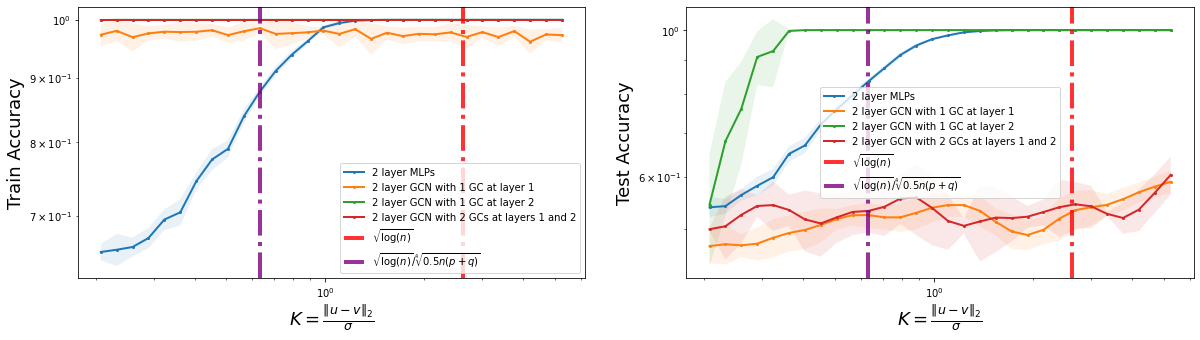

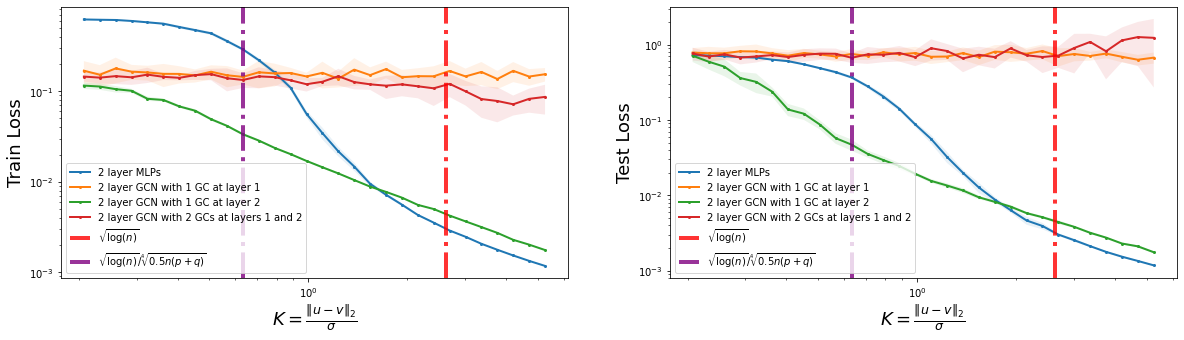

In [16]:
plot_metrics('Accuracy', train_acc, train_acc_std, test_acc, test_acc_std)
plot_metrics('Loss', train_loss, train_loss_std, test_loss, test_loss_std)